# Big Data Project
## Outcome: Divergence

In this notebook we will outcome 'Divergence'

'Divergence' will be used to detect matches with a big difference between bet houses quotas.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DataType, DecimalType
from pyspark.sql.functions import udf
import datetime
import pyspark

spark = SparkSession \
    .builder \
    .appName("Bets Exploring") \
    .getOrCreate()
    
sc = spark.sparkContext

sc

<SparkContext master=local[*] appName=Bets Exploring>

In [20]:
pathori = "../Data/Raw/Main/"
pathtemp = "../Data/Interim/"
pathdest = "../Data/Processed/"
filetemp = "main_competitions_consistent.csv"
filetemprecent = "main_competitions_consistent_recent.csv"
bethouses = ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
quotatypes = ['H','D','A']

In [21]:
# Open dataset
df = spark.read.csv(path = pathtemp + filetemprecent, header = True, inferSchema = True)
#df = df.withColumn("Date", df["Date"].cast("date"))

In [22]:
print ("Size:   ", df.count())
print ("Columns:", df.columns)
df.printSchema()

Size:    11374
Columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |-- IWD: double (nullable = true)
 |-- IWA: double (nullable = true)
 |-- LBH: double (nullable = true)
 |-- LBD: double (nullable = true)
 |-- LBA: double (nullable = true)
 |-- VCH: double (nul

In [23]:
df.show(5)

+-------+-------------+---------+---+-------------------+---------+----------------+---+-----+-----+-----+----+---+----+----+---+---+----+---+----+----+----+----+----+----+----+
|Country|  Competition|   Season|Div|               Date| HomeTeam|        AwayTeam|FTR|B365H|B365D|B365A| BWH|BWD| BWA| IWH|IWD|IWA| LBH|LBD| LBA| VCH| VCD| VCA| WHH| WHD| WHA|
+-------+-------------+---------+---+-------------------+---------+----------------+---+-----+-----+-----+----+---+----+----+---+---+----+---+----+----+----+----+----+----+----+
|Belgium|JupilerLeague|2017-2018| B1|2017-07-28 00:00:00|  Antwerp|      Anderlecht|  D| 5.75|  3.8|  1.6| 5.0|4.0|1.67| 4.7|3.6|1.7| 5.2|3.7|1.61| 5.5| 3.9|1.62|4.75|3.75|1.67|
|Belgium|JupilerLeague|2017-2018| B1|2017-07-29 00:00:00|Charleroi|        Kortrijk|  H| 1.62| 3.75|  5.5|1.67|3.7| 5.5| 1.6|3.7|5.4|1.61|3.6| 5.2|1.65| 3.8|5.25|1.65|3.75| 4.8|
|Belgium|JupilerLeague|2017-2018| B1|2017-07-29 00:00:00|    Eupen|         Waregem|  A|  2.6|  3.4|  2.6| 2.7

In [24]:
df.count()

11374

In [25]:
df.describe('Country','Competition','Season','Div','Date','HomeTeam','AwayTeam','FTR').show()

+-------+-------+------------+---------+-----+--------+--------+-----+
|summary|Country| Competition|   Season|  Div|HomeTeam|AwayTeam|  FTR|
+-------+-------+------------+---------+-----+--------+--------+-----+
|  count|  11374|       11374|    11374|11374|   11374|   11374|11374|
|   mean|   null|        null|     null| null|    null|    null| null|
| stddev|   null|        null|     null| null|    null|    null| null|
|    min|Belgium|Championship|2017-2018|   B1|     AEK|     AEK|    A|
|    max| Turkey|      SerieB|2018-2019|   T1|  Zwolle|  Zwolle|    H|
+-------+-------+------------+---------+-----+--------+--------+-----+



In [26]:
# df.describe('WHH','WHD','WHA','SBH','SBD','SBA','IWH','IWD','IWA','GBH','GBD','GBA').show()

In [29]:
# Bet Houses selection depending on dataset simulation
print ("Potential bet houses:", bethouses)
betHousesCols = []
betHousesOk = []
for bethouse in bethouses:
    col = bethouse + 'H'
    if col in df.columns:
        betHousesOk.append(bethouse)
        betHousesCols.append(bethouse + 'H')
        betHousesCols.append(bethouse + 'D')
        betHousesCols.append(bethouse + 'A')
        
print ("Bet houses selected :" , betHousesOk)
print ("Bet houses columns  :", betHousesCols)

Potential bet houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bet houses selected : ['B365', 'BW', 'IW', 'LB', 'VC', 'WH']
Bet houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']


In [30]:
# Divergence calculation simulation
match = df[betHousesCols].take(1)[0]
print (match)

quotatypes = ['H','D','A']
divergence = 0
for quotatype in quotatypes:
    print ()
    min = 1000
    max = 0
    sum = 0
    count = 0
    for bethouse in betHousesOk:
        col = bethouse + quotatype
        val = match[col]
        if not val is None:
            print (col, ':', val, end='  ')
            sum = sum + val
            count = count + 1
            if val > max:
                max = val
            if val < min:
                min = val
    if count > 0:
        mean = sum/count
        diverMax = ((max / mean) - 1)*100
        if diverMax > divergence:
            divergence = diverMax
        diverMin = (abs((min / mean) - 1))*100
        if diverMin > divergence:
            divergence = diverMin
    
    print ('\nCount:', count, end='  ')
    print ('Sum:', sum, end='  ')
    print ('Max:', max, end='  ')
    print ('Min:', min, end='  ')
    print ('Mean:', mean)
    print ('Diver Max:  ', diverMax, end='  ')
    print ('Diver Min:  ', diverMin, end='  ')
    print ('Divergence: ', divergence)
       

Row(B365H=5.75, B365D=3.8, B365A=1.6, BWH=5.0, BWD=4.0, BWA=1.67, IWH=4.7, IWD=3.6, IWA=1.7, LBH=5.2, LBD=3.7, LBA=1.61, VCH=5.5, VCD=3.9, VCA=1.62, WHH=4.75, WHD=3.75, WHA=1.67)

B365H : 5.75  BWH : 5.0  IWH : 4.7  LBH : 5.2  VCH : 5.5  WHH : 4.75  
Count: 6  Sum: 30.9  Max: 5.75  Min: 4.7  Mean: 5.1499999999999995
Diver Max:   11.65048543689322  Diver Min:   8.737864077669888  Divergence:  11.65048543689322

B365D : 3.8  BWD : 4.0  IWD : 3.6  LBD : 3.7  VCD : 3.9  WHD : 3.75  
Count: 6  Sum: 22.75  Max: 4.0  Min: 3.6  Mean: 3.7916666666666665
Diver Max:   5.494505494505497  Diver Min:   5.054945054945048  Divergence:  11.65048543689322

B365A : 1.6  BWA : 1.67  IWA : 1.7  LBA : 1.61  VCA : 1.62  WHA : 1.67  
Count: 6  Sum: 9.87  Max: 1.7  Min: 1.6  Mean: 1.6449999999999998
Diver Max:   3.3434650455927084  Diver Min:   2.7355623100303816  Divergence:  11.65048543689322


In [31]:
def filterBetHouses0(df, bethouses):
    betHousesCols = []
    betHousesOk = []
    for bethouse in bethouses:
        col = bethouse + 'H'
        if col in dfok.columns:
            betHousesOk.append(bethouse)
            betHousesCols.append(bethouse + 'H')
            betHousesCols.append(bethouse + 'D')
            betHousesCols.append(bethouse + 'A')

    return (betHousesOk, betHousesCols)

In [36]:
def filterBetHouses(df, bethouses):
    betHousesOk = []
    for bethouse in bethouses:
        col = bethouse + 'H'
        if col in df.columns:
            betHousesOk.append(bethouse)
    
    return betHousesOk

In [33]:
def calcDivergence(match, bethouses):
    resultList = ['H','D','A']
    divergence = 0
    for result in resultList:
        min = 1000
        max = 0
        sum = 0
        count = 0
        for bethouse in bethouses:
            col = bethouse + result
            val = match[col]
            if not val is None:
                sum = sum + val
                count = count + 1
                if val > max:
                    max = val
                if val < min:
                    min = val
        mean = sum/count
        diverMax = ((max / mean) - 1) * 100
        if diverMax > divergence:
            divergence = diverMax
        diverMin = (abs((min / mean) - 1)) * 100
        if diverMin > divergence:
            divergence = diverMin

    return divergence

In [37]:
# Map divergence
bethousesok = filterBetHouses(df, bethouses)
print ("Bet Houses:", bethousesok)

rdddiver = df.rdd.map(lambda match: (match, calcDivergence(match, bethousesok)))
#rddlist = dfok.rdd.map(list)
#rdddiver = rddlist.map(lambda match : (match, calcDivergence(match, bethouses)))
display (rdddiver.take(2))

Bet Houses: ['B365', 'BW', 'IW', 'LB', 'VC', 'WH']


[(Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 28, 0, 0), HomeTeam='Antwerp', AwayTeam='Anderlecht', FTR='D', B365H=5.75, B365D=3.8, B365A=1.6, BWH=5.0, BWD=4.0, BWA=1.67, IWH=4.7, IWD=3.6, IWA=1.7, LBH=5.2, LBD=3.7, LBA=1.61, VCH=5.5, VCD=3.9, VCA=1.62, WHH=4.75, WHD=3.75, WHA=1.67),
  11.65048543689322),
 (Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 29, 0, 0), HomeTeam='Charleroi', AwayTeam='Kortrijk', FTR='H', B365H=1.62, B365D=3.75, B365A=5.5, BWH=1.67, BWD=3.7, BWA=5.5, IWH=1.6, IWD=3.7, IWA=5.4, LBH=1.61, LBD=3.6, LBA=5.2, VCH=1.65, VCD=3.8, VCA=5.25, WHH=1.65, WHD=3.75, WHA=4.8),
  9.004739336492884)]

In [38]:
# Top N highest and lower divergence matches of a web - simulation
import datetime

date_ini = '2018-11-01'
date_end = '2018-11-07'
date_ini_obj = datetime.datetime.strptime(date_ini, '%Y-%m-%d')
date_end_obj = datetime.datetime.strptime(date_end, '%Y-%m-%d')
print ("Period: ", date_ini_obj, "to", date_end_obj)

rddperiod = rdddiver.filter(lambda match: match[0][4]>=date_ini_obj).filter(lambda match: match[0][4]<=date_end_obj)
print("Week matches: ", rddperiod.count())

# Top N highest
print ("* Top N highest divergence matches:")
display (rddperiod.top(5, key=lambda match: match[1]))

# Top N lowest
print ("* Top N lowest divergence matches:")
display (rddperiod.top(5, key=lambda match: -match[1]))


Period:  2018-11-01 00:00:00 to 2018-11-07 00:00:00
Week matches:  123
* Top N highest divergence matches:


[(Row(Country='Spain', Competition='Primera', Season='2017-2018', Div='SP1', Date=datetime.datetime(2018, 11, 2, 0, 0), HomeTeam='Barcelona', AwayTeam='Getafe', FTR='D', B365H=1.12, B365D=9.0, B365A=19.0, BWH=1.1, BWD=9.25, BWA=19.0, IWH=1.12, IWD=9.0, IWA=20.0, LBH=1.11, LBD=9.5, LBA=19.0, VCH=1.09, VCD=10.0, VCA=29.0, WHH=1.11, WHD=9.0, WHA=21.0),
  37.00787401574803),
 (Row(Country='France', Competition='Division2', Season='2017-2018', Div='F2', Date=datetime.datetime(2018, 11, 5, 0, 0), HomeTeam='Le Havre', AwayTeam='Tours', FTR='H', B365H=1.19, B365D=6.0, B365A=15.0, BWH=1.22, BWD=6.0, BWA=10.5, IWH=1.22, IWD=6.25, IWA=10.75, LBH=1.2, LBD=6.0, LBA=13.0, VCH=1.18, VCD=6.5, VCA=17.0, WHH=1.22, WHD=6.0, WHA=9.5),
  34.65346534653466),
 (Row(Country='Italy', Competition='SerieA', Season='2017-2018', Div='I1', Date=datetime.datetime(2018, 11, 3, 0, 0), HomeTeam='Juventus', AwayTeam='Udinese', FTR='H', B365H=1.22, B365D=6.5, B365A=13.0, BWH=1.25, BWD=5.75, BWA=13.0, IWH=1.25, IWD=6.0, I

* Top N lowest divergence matches:


[(Row(Country='Germany', Competition='Liga1', Season='2017-2018', Div='D1', Date=datetime.datetime(2018, 11, 2, 0, 0), HomeTeam='Werder Bremen', AwayTeam='Wolfsburg', FTR='H', B365H=2.14, B365D=3.39, B365A=3.39, BWH=2.1, BWD=3.3, BWA=3.4, IWH=2.1, IWD=3.4, IWA=3.5, LBH=2.05, LBD=3.3, LBA=3.5, VCH=2.15, VCD=3.4, VCA=3.6, WHH=2.05, WHD=3.4, WHA=3.6),
  3.09671272034302),
 (Row(Country='Germany', Competition='Liga2', Season='2017-2018', Div='D2', Date=datetime.datetime(2018, 11, 2, 0, 0), HomeTeam='Greuther Furth', AwayTeam='Dresden', FTR='H', B365H=2.5, B365D=3.2, B365A=2.79, BWH=2.45, BWD=3.25, BWA=2.85, IWH=2.5, IWD=3.2, IWA=2.75, LBH=2.45, LBD=3.2, LBA=2.75, VCH=2.5, VCD=3.3, VCA=2.88, WHH=2.45, WHD=3.3, WHA=2.7),
  3.349282296650724),
 (Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2018, 11, 3, 0, 0), HomeTeam='Genk', AwayTeam='Gent', FTR='A', B365H=2.1, B365D=3.5, B365A=3.25, BWH=2.2, BWD=3.5, BWA=3.25, IWH=2.1, IWD=3.3, IWA

In [39]:
# Calculate Top N higher and lowest divergence matches in a periode of time

def topNDivergence(rdd, date_ini, date_end):
    
    date_ini_obj = datetime.datetime.strptime(date_ini, '%Y-%m-%d')
    date_end_obj = datetime.datetime.strptime(date_end, '%Y-%m-%d')

    rddperiod = rdd.filter(lambda match: match[0][4]>=date_ini_obj).filter(lambda match: match[0][4]<=date_end_obj)

    rddhigh = rddperiod.top(5, key=lambda match: match[1])
    
    rddlow  = rddperiod.top(5, key=lambda match: -match[1])
    
    count = rdd.count()
    
    return (count, rddhigh, rddlow)


In [40]:
# Example of use of topNDivergence

topNDiver = topNDivergence(rdddiver, '2018-11-01', '2018-11-07')
print ("Matches:", topNDiver[0])
print ("\n* Top N highest divergence matches:")
print (topNDiver[1])
print ("\n* Top N lowest divergence matches:")
print (topNDiver[2])


Matches: 11374

* Top N highest divergence matches:
[(Row(Country='Spain', Competition='Primera', Season='2017-2018', Div='SP1', Date=datetime.datetime(2018, 11, 2, 0, 0), HomeTeam='Barcelona', AwayTeam='Getafe', FTR='D', B365H=1.12, B365D=9.0, B365A=19.0, BWH=1.1, BWD=9.25, BWA=19.0, IWH=1.12, IWD=9.0, IWA=20.0, LBH=1.11, LBD=9.5, LBA=19.0, VCH=1.09, VCD=10.0, VCA=29.0, WHH=1.11, WHD=9.0, WHA=21.0), 37.00787401574803), (Row(Country='France', Competition='Division2', Season='2017-2018', Div='F2', Date=datetime.datetime(2018, 11, 5, 0, 0), HomeTeam='Le Havre', AwayTeam='Tours', FTR='H', B365H=1.19, B365D=6.0, B365A=15.0, BWH=1.22, BWD=6.0, BWA=10.5, IWH=1.22, IWD=6.25, IWA=10.75, LBH=1.2, LBD=6.0, LBA=13.0, VCH=1.18, VCD=6.5, VCA=17.0, WHH=1.22, WHD=6.0, WHA=9.5), 34.65346534653466), (Row(Country='Italy', Competition='SerieA', Season='2017-2018', Div='I1', Date=datetime.datetime(2018, 11, 3, 0, 0), HomeTeam='Juventus', AwayTeam='Udinese', FTR='H', B365H=1.22, B365D=6.5, B365A=13.0, BWH=

In [41]:
# Obtain Dataframe to make graphic analisys
rddhist = rdddiver.map(lambda match: (match[0][0], match[0][1], match[0][2], match[0][4], match[0][5], match[0][6], round(match[1],2)))
print ('Matches:', rddhist.count())
print ('Sample data:\n', rddhist.take(2))

Matches: 11374
Sample data:
 [('Belgium', 'JupilerLeague', '2017-2018', datetime.datetime(2017, 7, 28, 0, 0), 'Antwerp', 'Anderlecht', 11.65), ('Belgium', 'JupilerLeague', '2017-2018', datetime.datetime(2017, 7, 29, 0, 0), 'Charleroi', 'Kortrijk', 9.0)]


In [42]:
dfhist = rddhist.toDF(['Country','Competition','Season','Date','HomeTeam','AwayTeam','Divergence'])
dfhist.show(5)
dfdiver = dfhist.select('Divergence')
dfdiver.summary('count','mean','stddev','min','10%','25%','50%','75%','90%','max').show()
quantile = dfdiver.approxQuantile('Divergence',[0.10,0.25,0.50,0.75,0.9],0)

+-------+-------------+---------+-------------------+---------+----------------+----------+
|Country|  Competition|   Season|               Date| HomeTeam|        AwayTeam|Divergence|
+-------+-------------+---------+-------------------+---------+----------------+----------+
|Belgium|JupilerLeague|2017-2018|2017-07-28 00:00:00|  Antwerp|      Anderlecht|     11.65|
|Belgium|JupilerLeague|2017-2018|2017-07-29 00:00:00|Charleroi|        Kortrijk|       9.0|
|Belgium|JupilerLeague|2017-2018|2017-07-29 00:00:00|    Eupen|         Waregem|      2.99|
|Belgium|JupilerLeague|2017-2018|2017-07-29 00:00:00|     Genk|Waasland-Beveren|     11.96|
|Belgium|JupilerLeague|2017-2018|2017-07-29 00:00:00|  Lokeren|     Club Brugge|      4.69|
+-------+-------------+---------+-------------------+---------+----------------+----------+
only showing top 5 rows

+-------+-----------------+
|summary|       Divergence|
+-------+-----------------+
|  count|            11373|
|   mean|8.418530730677897|
| stdde

In [43]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

In [44]:
diverhist = rdddiver.map(lambda row: row[1]).collect()
print (diverhist[:20])

[11.65048543689322, 9.004739336492884, 2.9879211697393604, 11.96487376509332, 4.686258935663212, 3.9999999999999702, 6.647807637906644, 6.267029972752036, 6.702412868632701, 6.060606060606066, 7.594264471587886, 7.641196013289053, 5.695687550854345, 6.770255271920078, 15.04424778761062, 12.923462986198242, 4.347826086956541, 6.730769230769251, 4.895104895104918, 11.911357340720219]


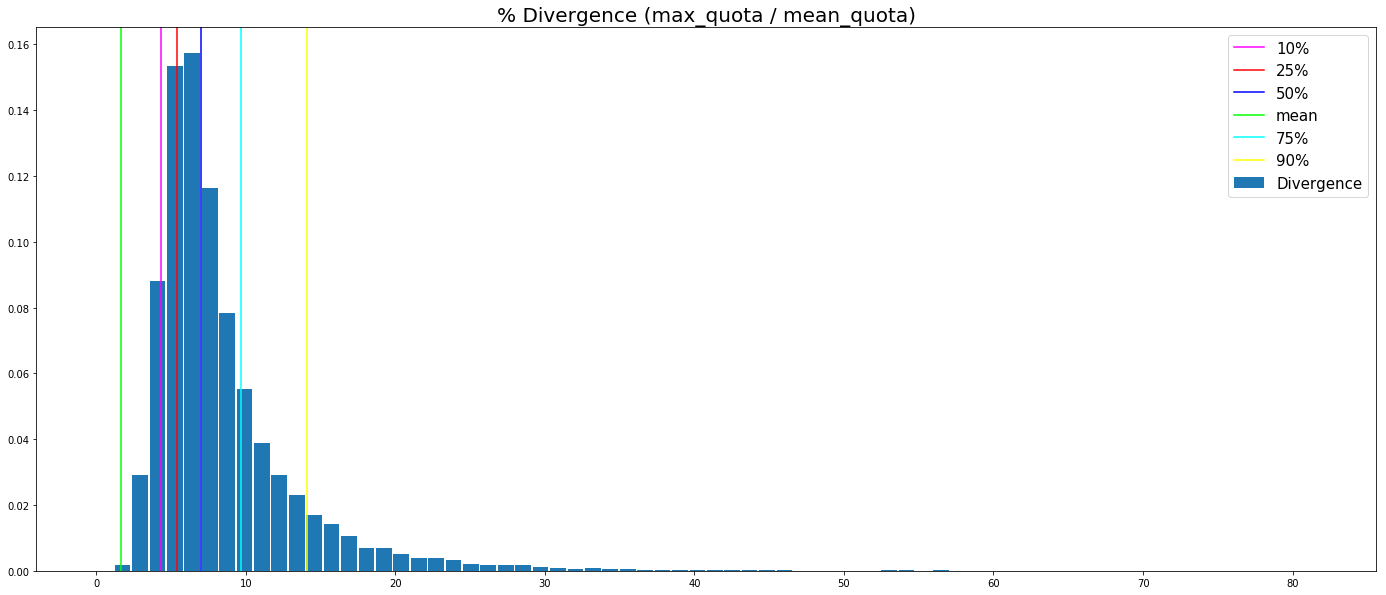

In [45]:
plt.hist(diverhist, bins=70, normed=True, rwidth=0.9, label='Divergence')
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.axvline(x=quantile[0], color='#ff00ff', label='10%')
plt.axvline(x=quantile[1], color='#ff0000', label='25%')
plt.axvline(x=quantile[2], color='#0000ff', label='50%')
plt.axvline(x=mean, color='#00ff00', label='mean')
plt.axvline(x=quantile[3], color='#00ffff', label='75%')
plt.axvline(x=quantile[4], color='#ffff00', label='90%')
plt.title('% Divergence (max_quota / mean_quota)', fontsize='20')
plt.legend(fontsize='15')
plt.show()

In [46]:
diverlow = rdddiver.filter(lambda row: row[1]<quantile[0]).map(lambda row: row[1]).collect()
print(diverlow[:20])

[2.9879211697393604, 3.9999999999999702, 3.4146341463414664, 3.4482758620689724, 4.270109235352515, 3.910614525139655, 4.211793020457266, 4.00616332819721, 3.6144578313252906, 3.4992607195662995, 3.2258064516129004, 4.232469993682897, 4.134762633996969, 2.6946107784431073, 4.098360655737698, 3.4992607195662995, 4.270109235352515, 3.826266804550149, 3.8834951456310773, 4.270109235352515]


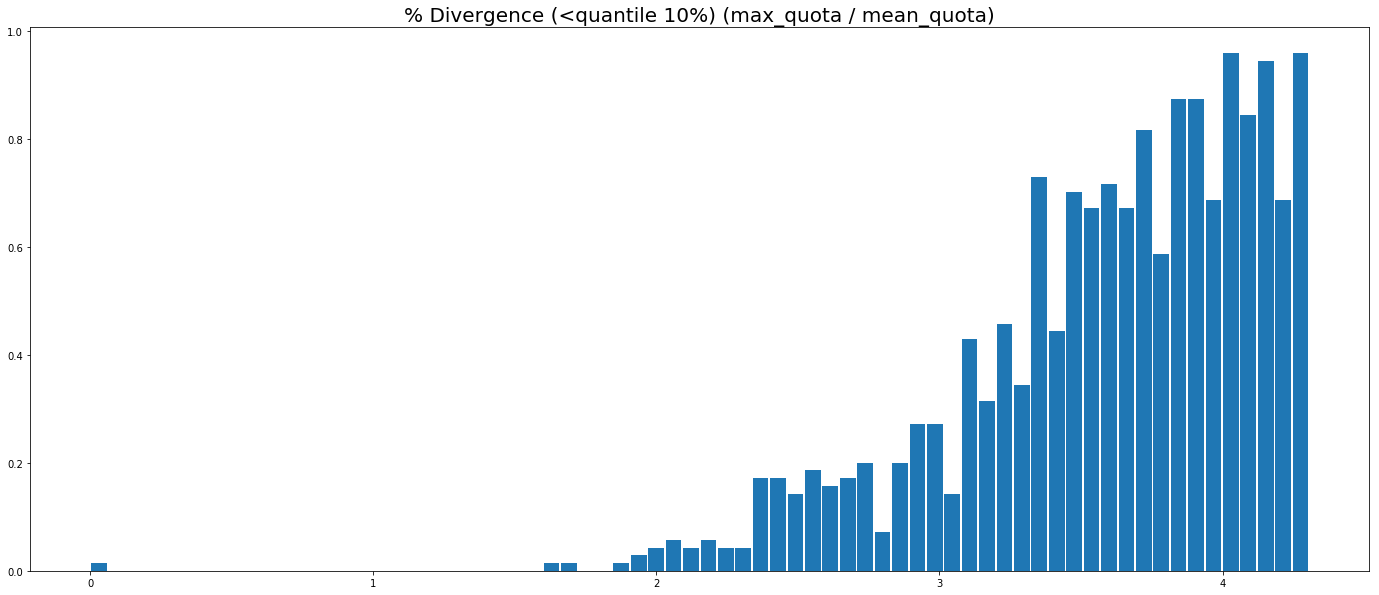

In [47]:

plt.hist(diverlow, bins=70, normed=True, rwidth=0.9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.title('% Divergence (<quantile 10%) (max_quota / mean_quota)', fontsize='20')
plt.show()

In [48]:
diverhigh = rdddiver.filter(lambda row: row[1]>quantile[4]).map(lambda row: row[1]).collect()
print(diverhigh[:20])

[15.04424778761062, 15.596330275229352, 20.398009950248753, 14.999999999999991, 14.155251141552494, 15.9235668789809, 14.28571428571428, 22.580645161290313, 14.48931116389549, 19.43462897526501, 22.26415094339622, 16.473317865429237, 15.021459227467815, 18.309859154929576, 18.8470066518847, 16.546762589928043, 15.867158671586722, 14.28571428571428, 16.455696202531644, 18.75]


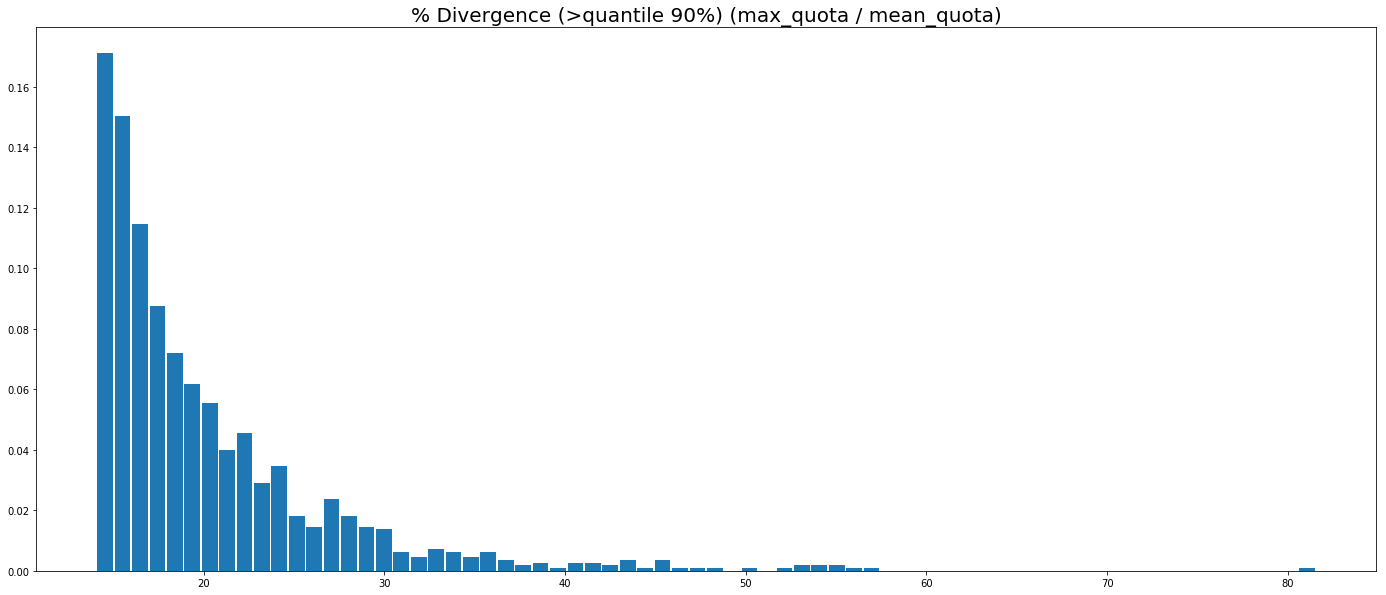

In [49]:
plt.hist(diverhigh, bins=70, normed=True, rwidth=0.9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.title('% Divergence (>quantile 90%) (max_quota / mean_quota)', fontsize='20')
plt.show()